In [101]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from src.pipeline import find_flux, find_noise_square, estimate_sigma
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")

In [ ]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '58.9_-48.6'

In [105]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/58.9_-48.6/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1460   111511R x 469C   [K, D, D, D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

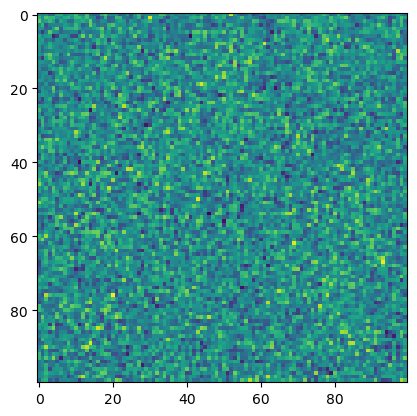

In [106]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    y0_rubin, x0_rubin, y1_rubin, x1_rubin = find_noise_square(hdul[1].data, 100)
    plt.imshow(hdul[1].data[y0_rubin:y1_rubin, x0_rubin:x1_rubin])
    plt.show()

In [107]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    image = hdu.data
    wcs = WCS(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)
mask = (x_c >= 0) & (x_c < nx) & (y_c >= 0) & (y_c < ny)
x_c[~mask] = np.nan
y_c[~mask] = np.nan

In [108]:
psf_file = [f for f in files if f.endswith("psf.fits")][0]
with fits.open(psf_file) as hdul:
    psf = hdul[0].data

In [ ]:
from scipy.optimize import curve_fit
def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    g = amplitude * np.exp(
        -(((x - x0)**2)/(2*sigma**2) + ((y - y0)**2)/(2*sigma**2))
    )
    return g.ravel()

In [110]:
original_sizes = np.linspace(2, 40, 20)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(ny//4, nx//4, ny // 8, nx // 8, original_size, original_size)
    weight_rescale = wiener_deconvolution(weight, psf, 0)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = 20

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    amplitude, weight_sigma, x0, y0 = popt
    weight_sigmas[i] = weight_sigma

Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function
Deconvolving weight function


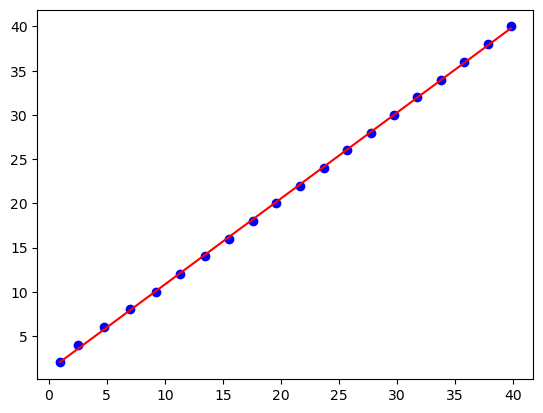

In [111]:
from numpy.polynomial import Polynomial

n = 1
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [112]:
print(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)))

0.9652707205447904 39.80154550065424


In [113]:
y = np.arange(image.shape[0])
x = np.arange(image.shape[1])
x, y = np.meshgrid(x, y)

# Flatten image and coordinates
xdata = np.vstack((x.ravel(), y.ravel()))
ydata = image.ravel()

amplitude_guess = np.mean(image)
sigma_guess = 3

initial_guess = [amplitude_guess, sigma_guess]

In [114]:
ny, nx = image.shape
half_size = 30
aperture_sizes = np.full(len(x_c), np.nan)
for i, (x_center, y_center) in enumerate(zip(x_c, y_c)):
    if np.isnan(x_center) or np.isnan(y_center):
        continue

    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - half_size)
    x_max = min(nx, x0 + half_size + 1)
    y_min = max(0, y0 - half_size)
    y_max = min(ny, y0 + half_size + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]

    # fit only the cutout
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        # print(f"Source {i}: Fitted sigma = {popt[1]:.2f} pixels")
        aperture_sizes[i] = np.abs(popt[1])
    except RuntimeError:
        continue
    if i % 1000 == 0:
        print(f"Processed {i} sources")

Processed 11000 sources
Processed 15000 sources
Processed 18000 sources
Processed 20000 sources
Processed 25000 sources
Processed 26000 sources
Processed 27000 sources
Processed 29000 sources
Processed 33000 sources
Processed 38000 sources
Processed 41000 sources
Processed 92000 sources
Processed 93000 sources
Processed 97000 sources


In [115]:
np.nanmean(aperture_sizes)

np.float64(477.12973820228723)

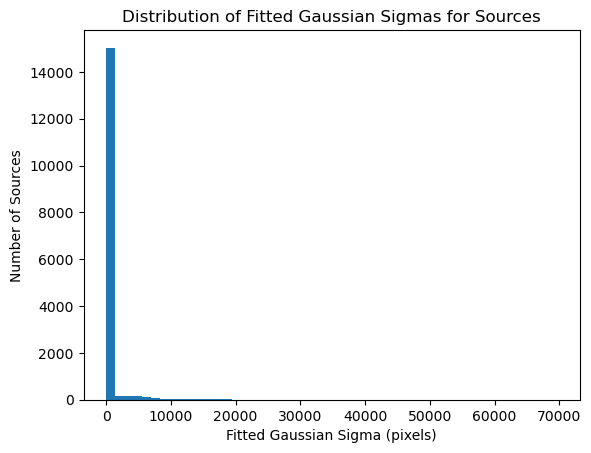

In [116]:
plt.hist(aperture_sizes[~np.isnan(aperture_sizes)], bins=50)
plt.xlabel('Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Distribution of Fitted Gaussian Sigmas for Sources')
plt.show()

[ 4.06948147  4.21085825  4.35714657  4.50851705  4.66514625  4.82721686
  4.99491793  5.16844505  5.34800064  5.53379411  5.72604219  5.92496911
  6.1308069   6.34379564  6.56418377  6.79222835  7.02819536  7.27236004
  7.52500718  7.78643147  8.05693783  8.33684177  8.62646979  8.9261597
  9.23626106  9.55713557  9.88915749 10.2327141  10.58820612 10.95604819
 11.33666937 11.7305136  12.13804028 12.55972473 12.99605881 13.44755146
 13.91472929 14.39813723 14.89833911 15.41591838 15.95147873 16.50564484
 17.07906308 17.6724023  18.28635457 18.92163598 19.57898754 20.25917598
 20.96299466 21.69126452 22.44483501 23.2245851  24.03142428 24.86629364
 25.73016698 26.62405192 27.54899108 28.5060633  29.49638492]


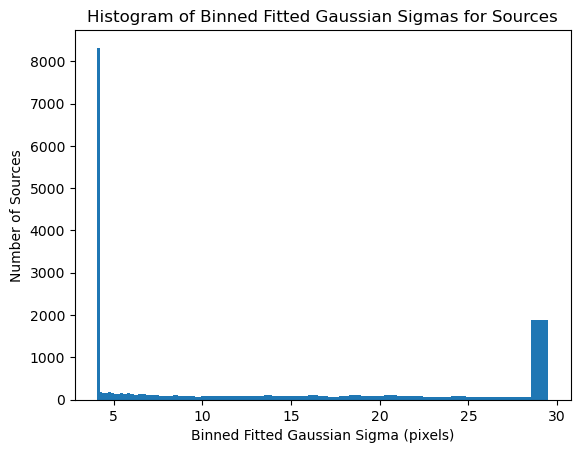

In [117]:
bins = np.logspace(np.log10(4), np.log10(30), 60)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# prepare array
sigma_binned = np.full_like(aperture_sizes, np.nan, dtype=float)

# mask valid (non-NaN) entries
mask = ~np.isnan(aperture_sizes)

# digitize only valid entries
bin_idx = np.digitize(aperture_sizes[mask], bins) - 1
bin_idx = np.clip(bin_idx, 0, len(bin_centers) - 1)

# assign binned values
sigma_binned[mask] = bin_centers[bin_idx]
print(np.unique(sigma_binned[~np.isnan(sigma_binned)]))
plt.hist(sigma_binned[~np.isnan(sigma_binned)], bins=bin_centers)
plt.xlabel('Binned Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Histogram of Binned Fitted Gaussian Sigmas for Sources')
plt.show()

In [118]:
fluxes = {}

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference
fluxes['binned_sigma'] = sigma_binned
rubin_filters = ['u', 'g', 'r', 'i', 'z', 'y']
for filter in rubin_filters:
    fluxes[f'flux_{filter}'] = np.full_like(ra_reference, np.nan)
    fluxes[f'flux_{filter}_sigma'] = np.full_like(ra_reference, np.nan)

In [120]:
for i, bin in enumerate(np.unique(sigma_binned[~np.isnan(sigma_binned)])):
    print(f'Processing bin {i} / {len(np.unique(sigma_binned[~np.isnan(sigma_binned)]))}')
    mask = sigma_binned == bin
    for filter in rubin_filters:
        files = glob.glob(f'{location}/{field}/{filter}_*.fits')
        image_file = [f for f in files if not f.endswith("psf.fits")][0]
        psf_file = [f for f in files if f.endswith("psf.fits")][0]

        flux_values, sigma = find_flux(
            image_file,
            "Rubin",
            f(bin),
            ra_reference[mask],
            dec_reference[mask],
            psf_path=psf_file,
            correlated=0,
            noise_x0=x0_rubin,
            noise_x1=x1_rubin,
            noise_y0=y0_rubin,
            noise_y1=y1_rubin
        )

        fluxes[f'flux_{filter}'][mask] = flux_values
        fluxes[f'flux_{filter}_sigma'][mask] = sigma

Processing bin 0 / 59
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Processing bin 1 / 59
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Processing bin 2 / 59
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Processing bin 3 / 59
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing im

In [121]:
df = pd.DataFrame(fluxes)

In [123]:
df[df['binned_sigma']>20]

,ra,dec,binned_sigma,flux_u,flux_u_sigma,flux_g,flux_g_sigma,flux_r,flux_r_sigma,flux_i,flux_i_sigma,flux_z,flux_z_sigma,flux_y,flux_y_sigma
10001,58.839071,-48.690688,29.496385,1.034710,0.277294,0.303871,0.060132,0.342590,0.144029,0.381687,0.247859,0.648651,0.307657,-1.038996,0.675522
10049,58.863779,-48.690533,29.496385,0.483876,0.277294,0.728981,0.060132,1.744491,0.144029,2.882360,0.247859,3.599006,0.307657,4.308207,0.675522
10061,59.028949,-48.690544,29.496385,0.949500,0.277294,0.722179,0.060132,0.832071,0.144029,1.253317,0.247859,2.192752,0.307657,1.632688,0.675522
10065,59.004445,-48.690495,20.962995,2.577276,0.398333,1.481268,0.085312,3.416233,0.203692,7.452385,0.349270,10.795146,0.435273,13.311767,0.955689
10070,58.904523,-48.690378,29.496385,1.829850,0.277294,0.652223,0.060132,0.915961,0.144029,1.383917,0.247859,1.388741,0.307657,2.049007,0.675522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98153,58.750078,-48.504794,21.691265,2.775634,0.383788,0.074909,0.082337,0.307711,0.196672,0.294210,0.337396,0.667359,0.420250,-0.866189,0.922724
98257,59.022002,-48.503467,29.496385,1.977345,0.277294,0.446896,0.060132,0.474943,0.144029,0.555835,0.247859,1.031993,0.307657,0.690555,0.675522
98285,58.749780,-48.502524,21.691265,2.416509,0.383788,0.728169,0.082337,1.438527,0.196672,2.203852,0.337396,2.424022,0.420250,2.338804,0.922724
98326,58.786610,-48.501849,29.496385,0.423652,0.277294,0.224760,0.060132,0.267139,0.144029,0.473104,0.247859,0.102288,0.307657,-0.052076,0.675522


In [124]:
df.to_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv', index=False)

In [68]:
df = pd.read_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv')

In [69]:
df

,ra,dec,binned_sigma,flux_u,flux_u_sigma,flux_g,flux_g_sigma,flux_r,flux_r_sigma,flux_i,flux_i_sigma,flux_z,flux_z_sigma,flux_y,flux_y_sigma
0,53.157185,-28.254257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52.816362,-28.254012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52.707227,-28.253847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52.761280,-28.253924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53.233772,-28.253921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96159,52.762204,-27.748261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96160,53.002813,-27.748525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96161,53.002641,-27.748209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96162,52.751111,-27.748058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


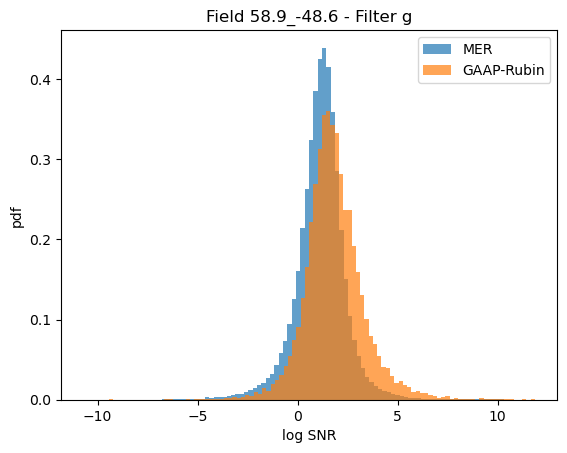

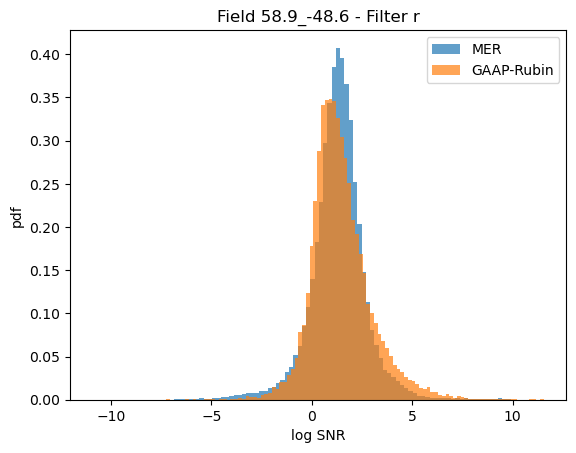

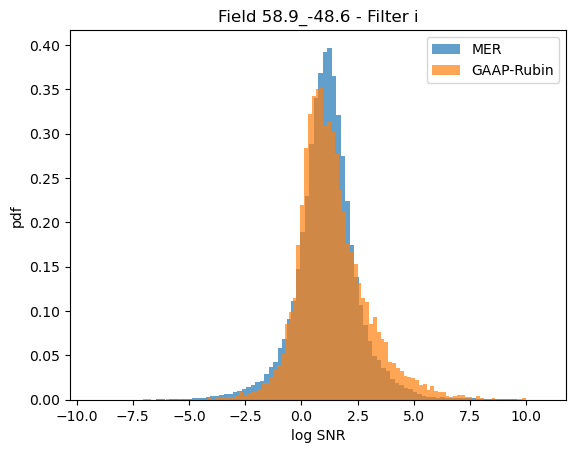

In [125]:
for filter in ['g', 'r', 'i']:
    plt.hist(np.log(cat[f'FLUX_{filter.upper()}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter.upper()}_EXT_DECAM_4FWHM_APER']), bins=100, density=True, alpha=0.7, label='MER')
    plt.hist(np.log(fluxes[f'flux_{filter}'][fluxes[f'flux_{filter}']>0]/fluxes[f'flux_{filter}_sigma'][fluxes[f'flux_{filter}']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Rubin')
    # plt.hist(np.log(fluxes['DES-G'][fluxes['DES-G']>0]/fluxes['DES-G_sigma'][fluxes['DES-G']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Euclid')
    plt.title(f'Field {field} - Filter {filter}')
    plt.xlabel('log SNR')
    plt.ylabel('pdf')
    plt.legend()
    plt.show()

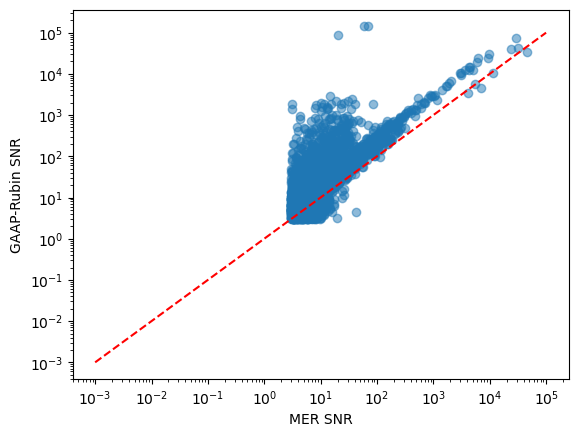

Percent of sources where GAAP-Rubin SNR > MER SNR: 0.890058155635558
Average SNR improvement factor (GAAP-Rubin / MER): 4.751053618657296


In [126]:
snr_meer = cat['FLUX_G_EXT_DECAM_4FWHM_APER'] / cat['FLUXERR_G_EXT_DECAM_4FWHM_APER']
snr_gaap = fluxes['flux_g']/fluxes['flux_g_sigma']
cutoff_snr = 3
mask = (snr_meer > cutoff_snr) & (snr_gaap > cutoff_snr) & (np.isfinite(snr_gaap)) & (np.isfinite(snr_meer))
plt.scatter(snr_meer[mask],
            snr_gaap[mask],
            alpha=0.5)
plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
plt.xlabel('MER SNR')
plt.ylabel('GAAP-Rubin SNR')
plt.loglog()
plt.show()
print("Percent of sources where GAAP-Rubin SNR > MER SNR:", np.nansum(snr_gaap[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap[mask])))
print("Average SNR improvement factor (GAAP-Rubin / MER):", np.nanmean(snr_gaap[mask] / snr_meer[mask]))

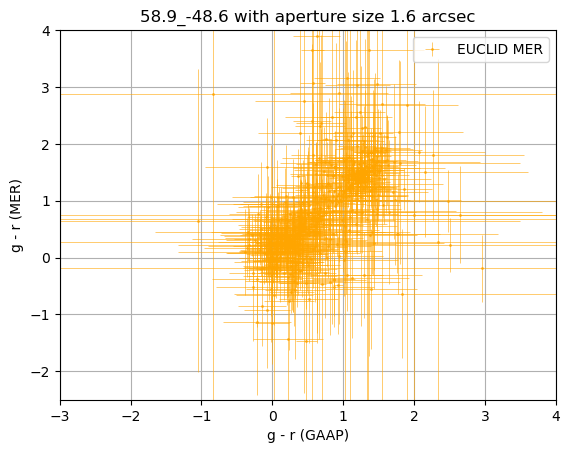

In [127]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    # y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    #     (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    # )

    # Optional: filter points with very large errors
    # mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # gaap_error = xerr**2 + yerr**2
    # # plt.show()
    # # Plot
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    # )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    y_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    # y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    # )

    mask = cat['POINT_LIKE_PROB'] > 0.1
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'g - r (GAAP)')
    plt.ylabel(f'g - r (MER)')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

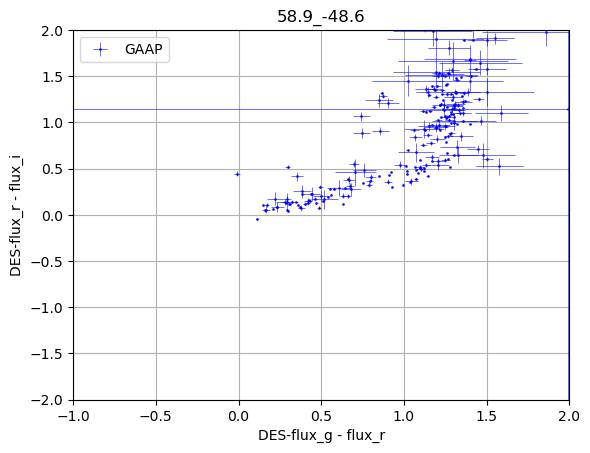

In [133]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = cat['POINT_LIKE_PROB'] > 0.9
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    gaap_error = xerr**2 + yerr**2
    # plt.show()
    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field}')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    # x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    # y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # # # Compute errors from sigma dictionary
    # xerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    # )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    # )

    # # mask = cat['POINT_LIKE_PROB'] > 0.6
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # euclid_error = xerr**2 + yerr**2
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    # )

    plt.title(f'{field}')
    plt.xlabel(f'DES-{filter_1} - {filter_2}')
    plt.ylabel(f'DES-{filter_3} - {filter_4}')
    plt.xlim(-1, 2)
    plt.ylim(-2, 2)
    plt.legend()
    plt.show()